# **Homework 2 - Name Entity Recognition (NER) task in zero-shot learning**
**Natural Language Processing** - a.a. 2024/25

**Group:**

- Chemello Francesco - 2121346.
- Volpato Pietro - 2120825.


In [ ]:
import os
import sys
from tqdm import tqdm
import numpy as np

# Gemini libraries
from google import genai
from google.genai import types

In [ ]:
# To manage environment variables
from google.colab import userdata

## **1 - Dataset**

In this section we introduce the dataset used for this homework: **CONLL-2003**.

### 1.1 - Dataset summary

The **CoNLL-2003** dataset is a pivotal resource in **Natural Language Processing**, specifically designed for the **Named Entity Recognition (NER)** task. Released as part of the CoNLL-2003 shared task on language-independent NER, it provides annotated text in both **English** (from the Reuters Corpus) and **German** (from the Frankfurter Rundschau newspaper).

The dataset organizes each word on a separate line, with sentences delineated by blank lines, and includes four key pieces of information per word: the word itself, its *Part-of-Speech* tag, a syntactic chunk tag, and its named entity tag. These named entities are categorized into **four** types:

- **ORGANIZATION (ORG)** - Organization entities such as *Georgia-Pacific Corp.*, *Apple*, or *Microsoft*.
- **PERSON (PER)** - People such as *Eddy Bonte*, *President Obama*, or *Paulo Dybala*.
- **LOCATION (LOC)** - Location entities such as *Murray River*, *Mount Everest*, or *Italy*.
- **MISCELLANEOUS (MISC)** - Miscellaneous entities such as *events*, *nationalities*, *products*, or *works of art*.

While the original dataset used the IOB1 tagging scheme, common versions (like those on [Hugging Face](https://huggingface.co/datasets/eriktks/conll2003)) often utilize the IOB2 scheme, where every new entity mention begins with a "B-" tag, making entity boundaries clearer. This structured format and comprehensive annotation have made CoNLL-2003 an enduring benchmark for evaluating and advancing NER models.

## 1.2 - Dataset availability and download

**CoNLL-2003** is readily available within `tensorflow_datasets` (TFDS), a convenient library that streamlines the process of accessing and preparing machine learning datasets for use with **TensorFlow** and other ML frameworks. By simply calling `tfds.load("conll2003")`, users can effortlessly download, parse, and obtain the dataset as `tf.data.Dataset` objects, automatically split into training, validation (dev), and test sets. This integration handles the underlying data structure, typically converting the raw text tokens and their associated *POS*, chunk, and *NER* tags into numerical representations suitable for model input, including the IOB2 scheme for named entity labels.

In [ ]:
# To download the dataset
import tensorflow_datasets as tfds

In [ ]:
# Download
ds, info = tfds.load("conll2003", split=['train', 'dev', 'test'], with_info=True)
train_ds, val_ds, test_ds = ds
print(info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/conll2003/conll2003/incomplete.P720NN_1.0.0/conll2003-train.tfrecord*...: …

Generating dev examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/conll2003/conll2003/incomplete.P720NN_1.0.0/conll2003-dev.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/conll2003/conll2003/incomplete.P720NN_1.0.0/conll2003-test.tfrecord*...:  …

Dataset conll2003 downloaded and prepared to /root/tensorflow_datasets/conll2003/conll2003/1.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='conll2003',
    full_name='conll2003/conll2003/1.0.0',
    description="""
    The shared task of CoNLL-2003 concerns language-independent named entity
    recognition and concentrates on four types of named entities: persons,
    locations, organizations and names of miscellaneous entities that do not belong
    to the previous three groups.
    """,
    homepage='https://www.aclweb.org/anthology/W03-0419/',
    data_dir='/root/tensorflow_datasets/conll2003/conll2003/1.0.0',
    file_format=tfrecord,
    download_size=959.94 KiB,
    dataset_size=3.87 MiB,
    features=FeaturesDict({
        'chunks': Sequence(ClassLabel(shape=(), dtype=int64, num_classes=23)),
        'ner': Sequence(ClassLabel(shape=(), dtype=int64, num_classes=9)),
        'pos': Sequence(ClassLabel(shape=(), dtype=int64, num_classes=47)),
        

In [ ]:
for example in train_ds.take(3):
    print("Tokens: ", example["tokens"].numpy())
    print("NER tags:", example["ner"].numpy())

Tokens:  [b'"' b'If' b'they' b"'re" b'saying' b'at' b'least' b'20' b'percent' b','
 b'then' b'their' b'internal' b'forecasts' b'are' b'probably' b'saying'
 b'25' b'or' b'30' b'percent' b',' b'"' b'said' b'one' b'Sydney' b'media'
 b'analyst' b'who' b'declined' b'to' b'be' b'named' b'.']
NER tags: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0]
Tokens:  [b'Lauck' b"'s" b'lawyer' b'vowed' b'he' b'would' b'appeal' b'against'
 b'the' b'court' b"'s" b'decision' b',' b'arguing' b'that' b'his'
 b'client' b'should' b'have' b'been' b'set' b'free' b'because' b'he'
 b'had' b'not' b'committed' b'any' b'offence' b'under' b'German' b'law'
 b'.']
NER tags: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0]
Tokens:  [b'Thailand' b"'s" b'powerful' b'military' b'thinks' b'the' b'government'
 b'is' b'dishonest' b'and' b'Prime' b'Minister' b'Banharn' b'Silpa-archa'
 b"'s" b'resignation' b'might' b'solve' b'the' b'nation' b"'s"
 b'political' b'and' b'economic' b'woes' 

In [ ]:
# Print the available NER tags
ner_label_names = info.features["ner"].names
print(ner_label_names)

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']


In [ ]:
sentences = []

# Iterate through the dataset correctly
for example in train_ds.take(3):
    # Access the tokens feature within each example
    tokens = example["tokens"].numpy().astype(str)
    sentence = " ".join(tokens)
    sentences.append(sentence)

In [ ]:
for s in sentences:
  print("Example of a phrase: ", s)

Example of a phrase:  " If they 're saying at least 20 percent , then their internal forecasts are probably saying 25 or 30 percent , " said one Sydney media analyst who declined to be named .
Example of a phrase:  Lauck 's lawyer vowed he would appeal against the court 's decision , arguing that his client should have been set free because he had not committed any offence under German law .
Example of a phrase:  Thailand 's powerful military thinks the government is dishonest and Prime Minister Banharn Silpa-archa 's resignation might solve the nation 's political and economic woes , an opinion poll showed on Thursday .


## 1.3 - Dataset Preprocessing for Zero-Shot Evaluation

Before performing the Named Entity Recognition (NER) task, the raw dataset undergoes a series of crucial preprocessing steps tailored for our **zero-shot learning** approach and API usage constraints.

Here are the operations involved:
- **Example Selection based on NER Tag Count:** We include only examples that contain at least `min_num_tags` NER tags. This ensures that the limited data we process focuses on instances rich in relevant entities, which is vital for evaluating the model's performance within our constrained setup.
- **Phrase Reconstruction and Tag Decoding:** Words are concatenated to reconstruct their original phrases. Simultaneously, the numerical NER tags are decoded back into their human-readable string labels (e.g., `'B-PER'`).
- **String concatenation and :** we concatenate words together to recreate the full phrase and we concatenate the NER tag, after a decoding.
- **Reproducible Random Shuffle:** The dataset is randomly shuffled using a fixed seed of 77 to ensure reproducibility when selecting our subset of examples.
- **Data Slicing for Evaluation:** Due to API usage limits and the zero-shot nature of our task, we select a small, representative sample of **thirty (30) examples** from the shuffled dataset. This focused subset is sufficient for assessing the AI model's foundational NER capabilities in this experimental context.
- **Word-NER Tag Pairing:** For evaluation, we create tuples pairing each word with its corresponding NER tag, such as `('Peter', 'B-PER')`. This format serves as our ground truth for assessing the model's classification accuracy.
- **Excluding 'O' (Non-Entity) Tags from Evaluation:** We intentionally exclude word pairs labeled with 'O' (Outside) tags during our evaluation. This decision is driven by three key factors:

  1. **Class Imbalance:** 'O' tags overwhelmingly dominate the CoNLL-2003 dataset.
  2. **Targeted Evaluation Focus:** Our primary goal is to specifically evaluate the AI's ability to detect and correctly classify positive named entities, rather than its general proficiency in identifying non-entity tokens.
  3. **Enhanced Error Salience:** By focusing solely on actual entities, any mislabeled or missed NER tag (a *False Positive* or *False Negative*) has a more pronounced impact on our calculated metrics. This prevents the large number of correctly predicted 'O' tags from disproportionately inflating overall accuracy and obscuring performance on the less frequent, yet more critical, entity types.

In [ ]:
# For "random" shuffle
import random

In [ ]:
# Hyperparameter for the minumum number of NER tags that an example should have to be taken into consideration.
min_num_tags = 4

In [ ]:
# Random shuffle of the examples in the training set
dataset_array = []

for example in train_ds:
  # Count the number of NER tags in the example
  num_tags = 0
  for tag in example["ner"].numpy():
    if tag != 0:
      num_tags += 1
  if num_tags >= min_num_tags:
    # Build the example
    tokens = example["tokens"].numpy().astype(str)
    sentence = " ".join(tokens)
    # Build the NER tag array
    ner_tags = example["ner"].numpy()
    ner_tag_array = []
    for tag in ner_tags:
      ner_tag_array.append(ner_label_names[tag])
    dataset_array.append((sentence, ner_tag_array))

# Print an example
print("Example: ", dataset_array[0])

random.seed(77)

# Shuffle with the random seed
random.shuffle(dataset_array)

# Keep only the first 30 examples
dataset_array = dataset_array[:30]

dataset_sentences_array = []
dataset_labels_array = []

# Create the two arrays for labels and examples
for (x, y) in dataset_array:
  dataset_sentences_array.append(x)
  dataset_labels_array.append(y)

# Print the length
print("Len sentence array: ", len(dataset_sentences_array))
print("Len true label array: ", len(dataset_labels_array))

Example:  ("A forensic scientist who examined the supposed skull of 19th century King Hintsa , a chief of President Nelson Mandela 's Xhosa tribe killed in battle by the British , said it was in fact the cranium of a European woman .", ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O'])
Len sentence array:  30
Len true label array:  30


In [ ]:
# Create word pair: ('word', 'NER tag')
print("A sentence before the operation: ", dataset_sentences_array[1])
print("A true label before the operation: ", dataset_labels_array[1])

wordpair_sentence_label = []

for i in range(0, len(dataset_labels_array)):
  wordpair_sentence = []
  sentence = dataset_sentences_array[i]
  label = dataset_labels_array[i]
  for i in range (0, len(label)):
    if label[i] != 'O':
      wordpair_sentence.append(((sentence.split(" "))[i], label[i]))
  wordpair_sentence_label.append(wordpair_sentence)

print("A sentence after the operation: ", wordpair_sentence_label[1])

A sentence before the operation:  144 Peter O'Malley ( Australia ) 71 73 , Costantino Rocca ( Italy )
A true label before the operation:  ['O', 'B-PER', 'I-PER', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'B-LOC', 'O']
A sentence after the operation:  [('Peter', 'B-PER'), ("O'Malley", 'I-PER'), ('Australia', 'B-LOC'), ('Costantino', 'B-PER'), ('Rocca', 'I-PER'), ('Italy', 'B-LOC')]


## **2 - NER task with Gemini by Google**

In this section, we're going to introduce the setup to perform the **NER task** in **zero-shot learning**, and the four model of **Google Gemini** used.

### 2.1 - Helper functions

To accurately assess the AI model's capabilities in performing the NER task, we've implemented two dedicated helper functions:
- **`metrics` Function:** This function is designed to calculate the core components required for performance evaluation: **True Positives (TP), False Positives (FP), and False Negatives (FN)**.
  1. **Extracting and Normalizing Predictions:** It begins by extracting all word-NER tag pairs (e.g., `('Peter', 'B-PER')`) from the model's raw text response. A crucial step here involves normalizing predictions where a multi-word entity might be incorrectly grouped into a single predicted tuple (e.g., `('New York', 'B-LOC')`). In such cases, the function intelligently splits them into their correct **IOB2 format**, like `('New', 'B-LOC')` and `('York', 'I-LOC')`.
  > *Note: This normalization is essential to align the model's output with the token-level **IOB2 tagging scheme** inherently used by the **CoNLL-2003** dataset's ground truth, enabling a fair and accurate comparison.*

  2. **Calculating TP and FP:** It then compares the normalized predicted pairs against the ground truth. A **True Positive (TP)** is counted when a predicted word pair exactly matches a pair in the ground truth. Any predicted word pair that does not match a corresponding entry in the ground truth is counted as a **False Positive (FP)**.

  3. **Calculating FN:** Finally, **False Negatives (FN)** are identified as word pairs present in the ground truth that were not predicted by the model.


- **`evaluation` Function:** Building upon the counts from the metrics function, this utility calculates the standard **NER** performance indicators:

  - **Precision:** Measures the accuracy of the positive predictions, defined as the ratio of correctly predicted positive labels **(TP)** to the total number of positive labels predicted by the model **(TP + FP)**.
  - **Recall:** Measures the model's ability to find all the positive labels, defined as the ratio of correctly predicted positive labels **(TP)** to the total number of actual positive labels in the ground truth **(TP + FN)**.
  - **F1-Score:** Represents the harmonic mean of precision and recall, providing a single balanced metric that reflects the overall accuracy of the model, especially valuable when dealing with imbalanced datasets.

In [ ]:
# Import for regular expression
import re

"""
This function calculate the value of:
- true positive (tp).
- false positive (fp).
- false negative (fn).

Returns: tp, fp, fn
"""
def metrics (predicted, true):

  tp = 0
  fp = 0
  fn = 0

  # Pattern that finds all the tuples inside the response
  predicted_tuple = re.findall(r'["\'](.*?)["\']\s*,\s*["\'](.*?)["\']', predicted)

  # Check if there are composed tuples and scompose them if present -> ex. ["New York", "B-LOC"] to ["New", "B-LOC"], ["Year", "I-LOC"]
  for (x,y) in predicted_tuple:
    if len(x.split(" ")) > 1:
      predicted_tuple.remove((x,y))
      # Get the tag (last part)
      y = y.split("-")[1]
      first_word = True
      for word in x.split(" "):
        # First B-y, other I-y
        if first_word:
          first_word = False
          predicted_tuple.append((word, "B-" + y))
        else:
          predicted_tuple.append((word, "I-" + y))

  # Calculate the true positive (tp) and the false positive (fp)
  temp_true = true.copy()
  for tup in predicted_tuple:
    if tup in temp_true:
      tp += 1
      temp_true.remove(tup)
    else:
      fp += 1

  # Calculate the false negative (fn)
  for tup in true:
    if tup not in predicted_tuple:
      fn += 1

  return tp, fp, fn

In [ ]:
"""
Function that calculate the value of:
- precision
- recall
- f1 score
"""
def evaluation (tp, fp, fn):
  precision = tp / (tp + fp) if tp + fp > 0 else 0
  recall = tp / (tp + fn) if tp + fn > 0 else 0
  f1 = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0

  return precision, recall, f1

### 2.2 - Prompting Strategies for Zero-Shot NER
To thoroughly evaluate the AI models' zero-shot Named Entity Recognition (NER) capabilities, **three** distinct prompting strategies were developed, each implemented as a dedicated Python function (`prompt_1`, `prompt_2`, and `prompt_3`). These functions define the specific instructions and context provided to the Large Language Models (LLMs) to elicit NER predictions.

---

Common Elements Across All Prompt Functions:

- **Task Definition:** Each prompt explicitly instructs the model to perform the "Name Entity Recognition (NER) task" on a given phrase.
- **Target Entity Types:** The models are consistently directed to identify **four** specific entity labels:
  - Location (LOC).
  - Organization (ORG).
  - Person (PER).
  - Miscellaneous (MISC).

- **IOB2 Tagging Scheme:** The prompts enforce the use of IOB (Inside, Outside, Beginning) prefixes, requiring tags like `B-PER` and `I-PER` instead of just `PER`, to ensure structured output compatible with standard NER evaluation.
- **Exclusion of 'O' Tags:** A crucial instruction is to "keep only the words with a relevant tag," meaning the models are explicitly told not to output 'O' (non-entity) tags, aligning with the evaluation focus described previously.
- **Output Format Specification:** Models are strictly guided to return results as a **list of tuples of word-tag** like: `("Albert", "B-PER")`.
- **Conciseness Instruction:** Each prompt ends with **"Answer with less words as possible"** to minimize extraneous model output.
- **Temperature Setting:** For reproducibility of results, the temperature parameter for all API calls is set to `0.0`, ensuring deterministic outputs from the models for the same prompt.

---

Individual Prompt Strategies:

- **`prompt_1` (Baseline Prompt):** This function serves as the baseline, representing the most straightforward zero-shot approach. It provides only the essential NER task instructions and entity definitions, without any additional contextual tips or guidance. The model relies solely on its pre-trained knowledge to perform the task.
- **`prompt_2` (Prompt with AI-Generated Tips):** This strategy attempts to enhance model performance by incorporating **automatically generated** "tips" for the NER task. Before processing sentences, an auxiliary `autowrite` function is invoked. This `autowrite` function itself prompts the LLM (the same model being evaluated or a different one) to generate a **list of helpful tips** for performing NER in a zero-shot setting. These AI-generated tips are then dynamically inserted into the main NER prompt, providing the model with potentially beneficial meta-guidance.
- **`prompt_3` (Prompt with Step-by-Step Guide):** This prompt aims to improve performance by providing the model with a detailed, explicit **"step-by-step guide"** on how to perform the NER task. The guide outlines a logical process, from understanding the sentence and tokenization to assigning tags with context, and even includes a self-correction step. This strategy tests whether breaking down the complex NER task into smaller, explicit steps helps the LLM achieve better results in a zero-shot context.

---

Operational Flow within Each Function:

- **Iteration:** Each prompt function iterates through the selected 30 dataset sentences (`dataset_sentences_array`), processing one sentence at a time.
- **API Interaction:** For each sentence, the corresponding prompt is sent to the specified model via the `client.models.generate_content` API call.
- **Metrics Calculation:** The raw text response from the model is then passed to the metrics helper function, along with the ground truth for that sentence (`wordpair_sentence_label[i]`), to calculate **True Positives, False Positives, and False Negatives**. These are accumulated for overall evaluation.
- **Rate Limit Management:** To prevent exceeding Google API usage limits (**RPM**), a `time.sleep(6)` is implemented after each successful API call.
- **Error Handling and Retries:** Robust try-except blocks are included to catch `RESOURCE_EXHAUSTED (429)` errors, indicating rate limit issues (**RPD**). Upon such an error, the process prints a warning, pauses for a longer duration (`time.sleep(15)`), and attempts to re-process the problematic sentence by decrementing the loop counter (`i = i - 1`). If the rate limit persists, the function returns early.
- **Progress Tracking:** A `tqdm` progress bar is used to provide visual feedback on the processing status of the dataset.

In [ ]:
"""
Promt for the NER task with no extra information
"""
def prompt_1(model, dataset_sentences_array, wordpair_sentence_label):
  tp, fp, fn = 0, 0, 0

  progress_bar = tqdm(total=len(dataset_sentences_array))

  for i in range (0, len(dataset_sentences_array)):

    # Prompt for the NER task
    prompt = """Do the Name Entity Recognition (also known as NER) task to a following phrase I will give you.
    The only entity labels that could appear in the phrase are:
      - Location (LOC).
      - Organization (ORG).
      - Person (PER).
      - Miscellaneos (MISC).
    You have to use prefixes B (for begin) or I (for inside) together with a tag in the list ahead (for example use "B-PER" and not just "PER").

    You must keep only the words with a relevant tag (the ones I've listed before).

    The result must be in a list of tuples of word-tag like: ("Albert", "B-PER").

    Answer with less words as possible.

    Your phrase is: """ + dataset_sentences_array[i] + """

    Result:
    """

    try:
      response = client.models.generate_content(
          model=model,
          config={
              "temperature": 0.0,  # Set the temperature to 0 for reproducibility
          },
          contents=prompt,
      )

      tem_tp, tem_fp, tem_fn = metrics(response.text, wordpair_sentence_label[i])

      tp += tem_tp
      fp += tem_fp
      fn += tem_fn

      # Sleep to not exeed the API limit
      time.sleep(6)

      progress_bar.update(1)

    # An error occured (probably Gemini is overloaded), so wait 15 seconds
    except Exception as e:
      # Check if the error is releated to the API usage exceeds
      if "429 RESOURCE_EXHAUSTED" in str(e):
        progress_bar.close()
        print(f"API rate limit exceeds at sentence {i}.\nTry with a different model or try again later.")
        # No value for true positive (tp), false positive (fp), and false negative (fn)
        return [0, 0, 0]

      time.sleep(15)

      # Try again
      i = i - 1

  progress_bar.close()

  return [tp, fp, fn]

In [ ]:
"""
A function that write a list of tips to perform the NER task better
"""

def autowrite(model):
  autowrite = """You must perform a Named Entity Recognition (NER) task on a sentence in a zero-shot setting.
  Your goal is to assign a tag to each word, identifying named entities with the highest possible accuracy.

  You may consult a short list of classification tips to guide you.

  Write this list in the following format:
    - Tip 1: [your tip here].
    - Tip 2: [your tip here].
    - Tip 3: [your tip here].
    ...

  Keep each tip short, clear, and specific.

  IMPORTANT:
  - Only assign entity tags to proper nouns or multi-word expressions that refer to people (PER), locations (LOC), organizations (ORG), or miscellaneous entities (MISC).
  - Do **not** assign entity tags to verbs, articles, pronouns, or generic nouns unless they are clearly part of a named entity.
  - Prefer precision over recall: if in doubt, tag as "O".

  Now write your list of tips:
  """
  while(1):
    try:
      autowrite_response = client.models.generate_content(
          model=model,
          config={
              "temperature": 0.0,  # Set the temperature to 0 for reproducibility
          },
          contents=autowrite,
      )

      return autowrite_response.text

    # An error occured (probably Gemini is overloaded), so wait 15 seconds
    except Exception as e:
      # Check if the error is releated to the API usage exceeds
      if "429" in str(e):
        print(f"API rate limit exceeds at sentence {i}.\nTry with a different model or try again later.")
        return [0,0,0]

      time.sleep(15)

In [ ]:
"""
Prompt for NER task with the tips created through the function "autowrite"
"""
def prompt_2(model, dataset_sentences_array, wordpair_sentence_label):

  # Create the tips list
  tips_autowrite = autowrite(model)

  tp, fp, fn = 0, 0, 0

  progress_bar = tqdm(total=len(dataset_sentences_array))

  for i in range (0, len(dataset_sentences_array)):

    # Prompt for the NER task
    prompt = """
    Do the Name Entity Recognition (also known as NER) task to a following phrase I will give you.
    The only entity labels that could appear in the phrase are:
      - Location (LOC).
      - Organization (ORG).
      - Person (PER).
      - Miscellaneos (MISC).
    You have to use prefixes B (for begin) or I (for inside) together with a tag in the list ahead (for example use "B-PER" and not just "PER").

    You must keep only the words with a relevant tag (the ones I've listed before).

    The result must be in a list of tuples of word-tag like: ("Albert", "B-PER").

    Here some tips that you can find useful:
    """ + tips_autowrite + """

    Answer with less words as possible.

    Your phrase is: """ + dataset_sentences_array[i] + """

    Result:
    """

    try:
      response = client.models.generate_content(
          model=model,
          config={
              "temperature": 0.0,  # Set the temperature to 0 for reproducibility
          },
          contents=prompt,
      )

      tem_tp, tem_fp, tem_fn = metrics(response.text, wordpair_sentence_label[i])

      tp += tem_tp
      fp += tem_fp
      fn += tem_fn

      # Sleep to not exeed the API limit
      time.sleep(6)

      progress_bar.update(1)

    # An error occured (probably Gemini is overloaded), so wait 15 seconds
    except Exception as e:
      # Check if the error is releated to the API usage exceeds
      if "429" in str(e):
        progress_bar.close()
        print(f"API rate limit exceeds at sentence {i}.\nTry with a different model or try again later.")
        # No value for true positive (tp), false positive (fp), and false negative (fn)
        return [0, 0, 0]

      time.sleep(15)

      # Try again
      i = i - 1

  progress_bar.close()

  return [tp, fp, fn]

In [ ]:
"""
Prompt for NER task with a step-by-step guide
"""
def prompt_3(model, dataset_sentences_array, wordpair_sentence_label):
  tp, fp, fn = 0, 0, 0

  progress_bar = tqdm(total=len(dataset_sentences_array))

  for i in range (0, len(dataset_sentences_array)):

    # Prompt for the NER task
    prompt = """
    Do the Name Entity Recognition (also known as NER) task to a following phrase I will give you.
    The only entity labels that could appear in the phrase are:
      - Location (LOC).
      - Organization (ORG).
      - Person (PER).
      - Miscellaneos (MISC).
    You have to use prefixes B (for begin) or I (for inside) together with a tag in the list ahead (for example use "B-PER" and not just "PER").

    Here a step-by-step guide to perform the NER task correctly:
      - Step 1: Read the full sentence and understand its overall meaning. Identify the key subjects, actions, and context.
      - Step 2: Split the sentence into individual words or tokens using whitespace and punctuation as delimiters (e.g., like string.split(" ") in Python).
      - Step 3: For each token, assign one and only one NER tag from the following set:
        - Location (LOC).
        - Organization (ORG).
        - Person (PER).
        - Miscellaneos (MISC).
        - Other, not a named entity (O).
      - Step 4: Use a context window of ±2 tokens to help disambiguate the meaning of each word before assigning a tag. Consider capitalization, surrounding words, and known patterns.
      - Step 5: Repeat step 3 for every token in the sentence, producing a complete list of (token, tag) pairs.
      - Step 6: Reread the sentence together with the assigned tags. Check whether the overall meaning is consistent with what you understood in step 1.
      - Step 7: If the meaning has changed or seems incorrect due to tagging errors, remove all tags and repeat from step 3 using a revised interpretation.
      - Step 8: Once the tagged sentence preserves the original meaning and all entities are accurately labeled, the NER process is complete.

    You must keep only the words with a relevant tag (the ones I've listed before).

    The result must be in a list of tuples of word-tag like: ("Albert", "B-PER").

    Answer with less words as possible.

    Your phrase is: """ + dataset_sentences_array[i] + """

    Result:
    """

    try:
      response = client.models.generate_content(
          model=model,
          config={
              "temperature": 0.0,  # Set the temperature to 0 for reproducibility
          },
          contents=prompt,
      )

      tem_tp, tem_fp, tem_fn = metrics(response.text, wordpair_sentence_label[i])

      tp += tem_tp
      fp += tem_fp
      fn += tem_fn

      # Sleep to not exeed the API limit
      time.sleep(6)

      progress_bar.update(1)

    # An error occured (probably Gemini is overloaded), so wait 15 seconds
    except Exception as e:
      # Check if the error is releated to the API usage exceeds
      if "429" in str(e):
        progress_bar.close()
        print(f"API rate limit exceeds at sentence {i}.\nTry with a different model or try again later.")
        # No value for true positive (tp), false positive (fp), and false negative (fn)
        return [0, 0, 0]

      time.sleep(15)

      # Try again
      i = i - 1

  progress_bar.close()

  return [tp, fp, fn]

## 2.3 - Models and API Usage

In this homework, we utilized **four** distinct AI models accessed directly through the **Google API** for our **zero-shot NER task**. These models include:

- **`gemini-2.0-flash`:** A highly efficient and versatile model from the Gemini API family.
- **`gemini-2.0-flash-lite`:** A lighter-weight variant of the Gemini Flash model, also accessed via the API.
- **`gemma-3-4b-it`:** A Google-developed model from the Gemma series, specifically identified as a 4 billion parameter version tailored for Italian (indicated by the -it suffix).
- **`gemma-3-27b-it`:** A larger, more capable Google-developed model from the Gemma series, with 27 billion parameters and similarly focused on Italian language processing.

The table below outlines the free tier availability and usage limits, specified in **Requests Per Minute (RPM)** and **Requests Per Day (RPD)**, for the API models utilized.

> *Note: The accompanying figure is presented in Italian due to the licensing and regional settings under which the API access was granted.*

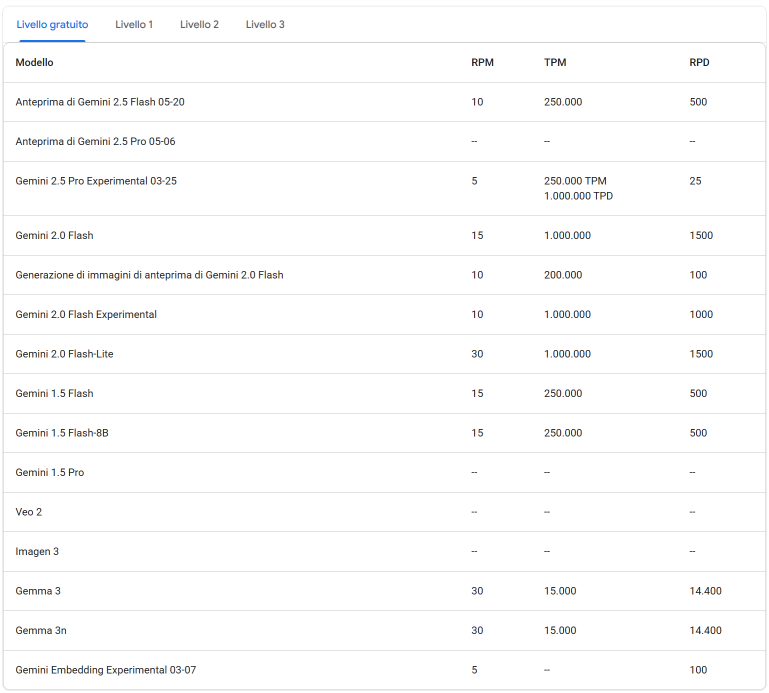

In [ ]:
# Get the API key from the environment of Google Colab (a.k.a Secrets)
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
client = genai.Client(api_key=GOOGLE_API_KEY)

In [ ]:
# Model loop
model_list = ["gemini-2.0-flash", "gemini-2.0-flash-lite", "gemma-3-4b-it", "gemma-3-27b-it"]
model_result = []

for model in model_list:
  # Call to the prompt 1

  values = prompt_1(model, dataset_sentences_array, wordpair_sentence_label)
  precision, recall, f1 = evaluation(values[0], values[1], values[2])

  # Add the results to the model_result array
  model_result.append(precision)
  model_result.append(recall)
  model_result.append(f1)

  # Print out the score
  print("Results for prompt 1 with model " + model + ": ")
  print("Recall: ", recall)
  print("Precision: ", precision)
  print("F1: ", f1)

  # Call to the prompt 2

  tp, fp, fn = prompt_2(model, dataset_sentences_array, wordpair_sentence_label)
  precision, recall, f1 = evaluation(tp, fp, fn)

  # Add the results to the model_result array
  model_result.append(precision)
  model_result.append(recall)
  model_result.append(f1)

  # Print out the score
  print("Results for prompt 2 with model " + model + ": ")
  print("Recall: ", recall)
  print("Precision: ", precision)
  print("F1: ", f1)

  # Call to the prompt 3

  tp, fp, fn = prompt_3(model, dataset_sentences_array, wordpair_sentence_label)
  precision, recall, f1 = evaluation(tp, fp, fn)

  # Add the results to the model_result array
  model_result.append(precision)
  model_result.append(recall)
  model_result.append(f1)

  # Print out the score
  print("Results for prompt 3 with model " + model + ": ")
  print("Recall: ", recall)
  print("Precision: ", precision)
  print("F1: ", f1)

  print("\n")

100%|██████████| 30/30 [03:21<00:00,  6.72s/it]


Results for prompt 1 with model gemini-2.0-flash: 
Recall:  0.8511904761904762
Precision:  0.9285714285714286
F1:  0.8881987577639753


100%|██████████| 30/30 [03:22<00:00,  6.76s/it]


Results for prompt 2 with model gemini-2.0-flash: 
Recall:  0.8757396449704142
Precision:  0.9135802469135802
F1:  0.8942598187311177


100%|██████████| 30/30 [03:21<00:00,  6.72s/it]


Results for prompt 3 with model gemini-2.0-flash: 
Recall:  0.8928571428571429
Precision:  0.9090909090909091
F1:  0.9009009009009009




100%|██████████| 30/30 [03:17<00:00,  6.58s/it]


Results for prompt 1 with model gemini-2.0-flash-lite: 
Recall:  0.8273809523809523
Precision:  0.9391891891891891
F1:  0.8797468354430379


100%|██████████| 30/30 [03:18<00:00,  6.62s/it]


Results for prompt 2 with model gemini-2.0-flash-lite: 
Recall:  0.8562874251497006
Precision:  0.9166666666666666
F1:  0.8854489164086686


100%|██████████| 30/30 [03:17<00:00,  6.60s/it]


Results for prompt 3 with model gemini-2.0-flash-lite: 
Recall:  0.7964071856287425
Precision:  0.9366197183098591
F1:  0.8608414239482202




100%|██████████| 30/30 [03:35<00:00,  7.19s/it]


Results for prompt 1 with model gemma-3-4b-it: 
Recall:  0.5297619047619048
Precision:  0.6496350364963503
F1:  0.5836065573770493


100%|██████████| 30/30 [03:36<00:00,  7.21s/it]


Results for prompt 2 with model gemma-3-4b-it: 
Recall:  0.5297619047619048
Precision:  0.689922480620155
F1:  0.5993265993265993


100%|██████████| 30/30 [03:39<00:00,  7.31s/it]


Results for prompt 3 with model gemma-3-4b-it: 
Recall:  0.6666666666666666
Precision:  0.5989304812834224
F1:  0.6309859154929577




100%|██████████| 30/30 [03:44<00:00,  7.48s/it]


Results for prompt 1 with model gemma-3-27b-it: 
Recall:  0.8224852071005917
Precision:  0.8853503184713376
F1:  0.8527607361963191


 90%|█████████ | 27/30 [04:12<00:28,  9.34s/it]


Results for prompt 2 with model gemma-3-27b-it: 
Recall:  0.8421052631578947
Precision:  0.8767123287671232
F1:  0.8590604026845637


100%|██████████| 30/30 [03:45<00:00,  7.52s/it]

Results for prompt 3 with model gemma-3-27b-it: 
Recall:  0.7844311377245509
Precision:  0.8675496688741722
F1:  0.8238993710691823




## 3 - Conclusion
[conclusion here]

In [ ]:
import matplotlib.pyplot as plt

# Set the figure size
plt.rcParams["figure.figsize"] = (13, 10)

In [ ]:
y_precision = np.array([])
y_recall = np.array([])
y_f1_score = np.array([])

for i in range (0, len(model_result), 3):
  y_precision = np.append(y_precision, model_result[i])
  y_recall = np.append(y_recall, model_result[i + 1])
  y_f1_score = np.append(y_f1_score, model_result[i + 2])

### 3.1 - Results for model *'gemini-2.0-flash'*

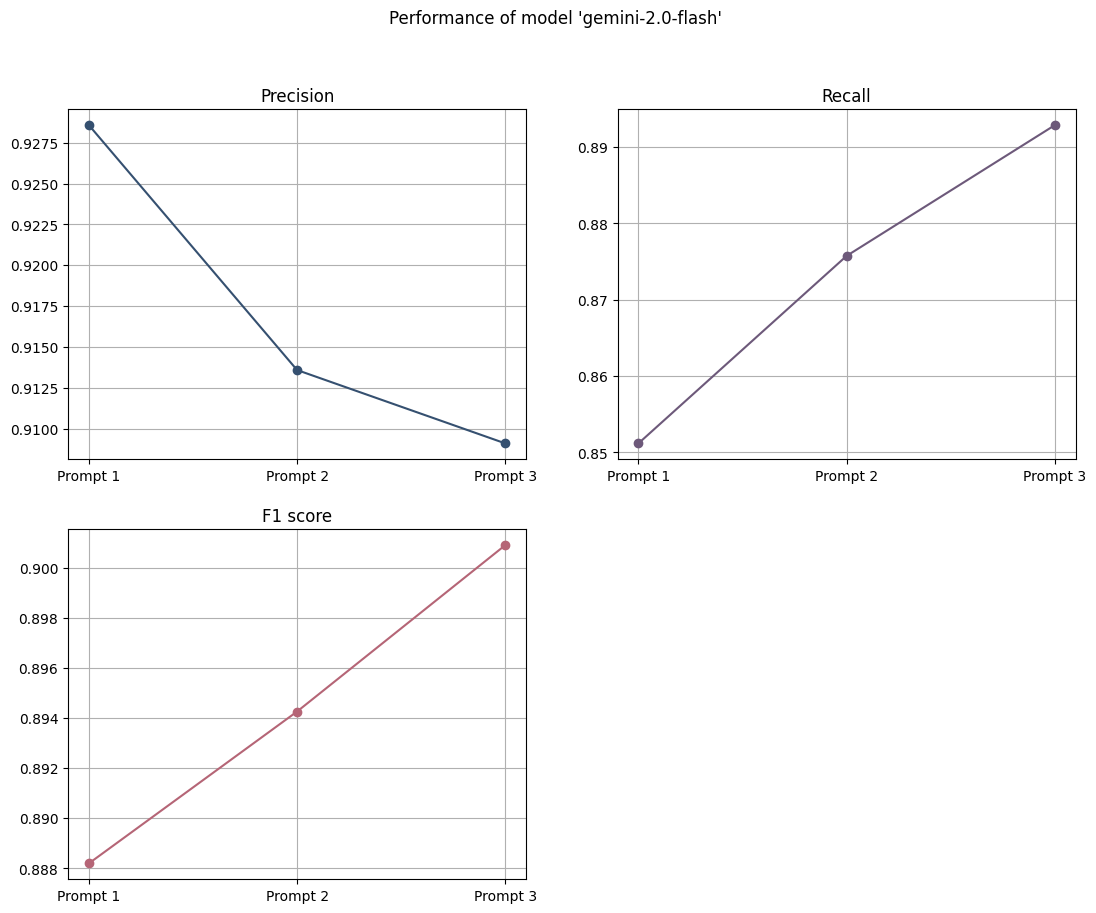

In [ ]:
x = np.array(["Prompt 1","Prompt 2","Prompt 3"])

plt.subplot(2, 2, 1)
y = np.array(y_precision[0:3])
plt.title("Precision")
plt.plot(x,y, color='#355070', marker = 'o')
plt.grid()

plt.subplot(2, 2, 2)
y = np.array(y_recall[0:3])
plt.title("Recall")
plt.plot(x,y, color='#6d597a', marker = 'o')
plt.grid()

plt.subplot(2, 2, 3)
y = np.array(y_f1_score[0:3])
plt.title("F1 score")
plt.plot(x,y, color='#b56576', marker = 'o')
plt.grid()

plt.suptitle("Performance of model 'gemini-2.0-flash'")
plt.show()

### 3.2 - Results for model *'gemini-2.0-flash-lite'*

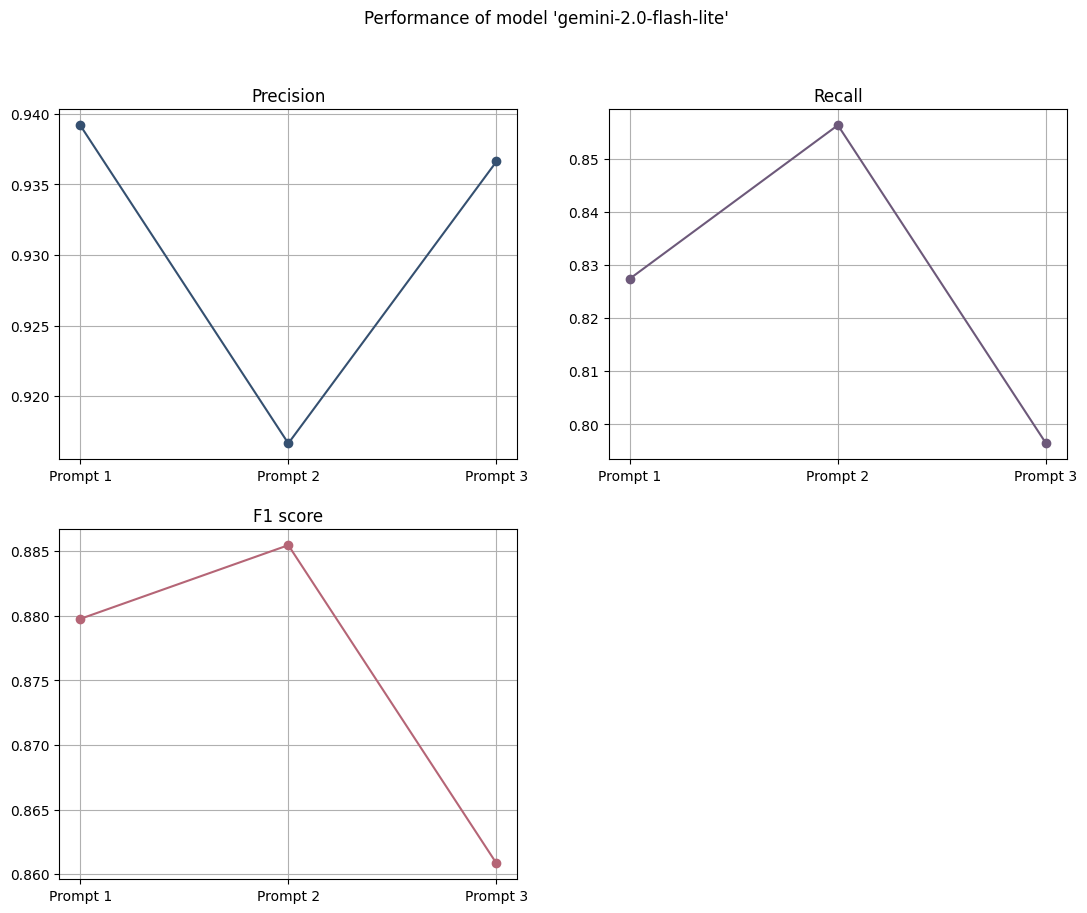

In [ ]:
x = np.array(["Prompt 1","Prompt 2","Prompt 3"])

plt.subplot(2, 2, 1)
y = np.array(y_precision[3:6])
plt.title("Precision")
plt.plot(x,y, color='#355070', marker = 'o')
plt.grid()

plt.subplot(2, 2, 2)
y = np.array(y_recall[3:6])
plt.title("Recall")
plt.plot(x,y, color='#6d597a', marker = 'o')
plt.grid()

plt.subplot(2, 2, 3)
y = np.array(y_f1_score[3:6])
plt.title("F1 score")
plt.plot(x,y, color='#b56576', marker = 'o')
plt.grid()

plt.suptitle("Performance of model 'gemini-2.0-flash-lite'")
plt.show()

### 3.3 - Results for model *'gemma-3-4b-it'*

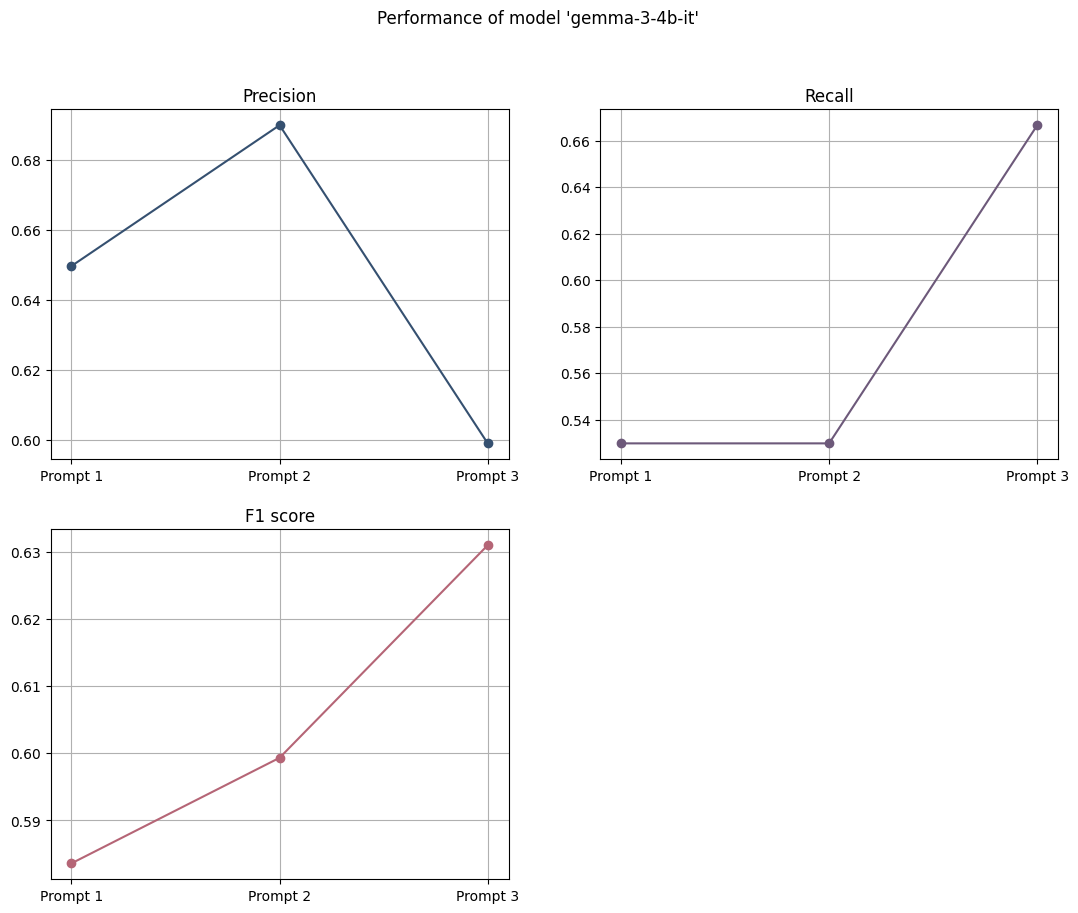

In [ ]:
x = np.array(["Prompt 1","Prompt 2","Prompt 3"])

plt.subplot(2, 2, 1)
y = np.array(y_precision[6:9])
plt.title("Precision")
plt.plot(x,y, color='#355070', marker = 'o')
plt.grid()

plt.subplot(2, 2, 2)
y = np.array(y_recall[6:9])
plt.title("Recall")
plt.plot(x,y, color='#6d597a', marker = 'o')
plt.grid()

plt.subplot(2, 2, 3)
y = np.array(y_f1_score[6:9])
plt.title("F1 score")
plt.plot(x,y, color='#b56576', marker = 'o')
plt.grid()

plt.suptitle("Performance of model 'gemma-3-4b-it'")
plt.show()

### 3.4 - Results for model *'gemma-3-27b-it'*

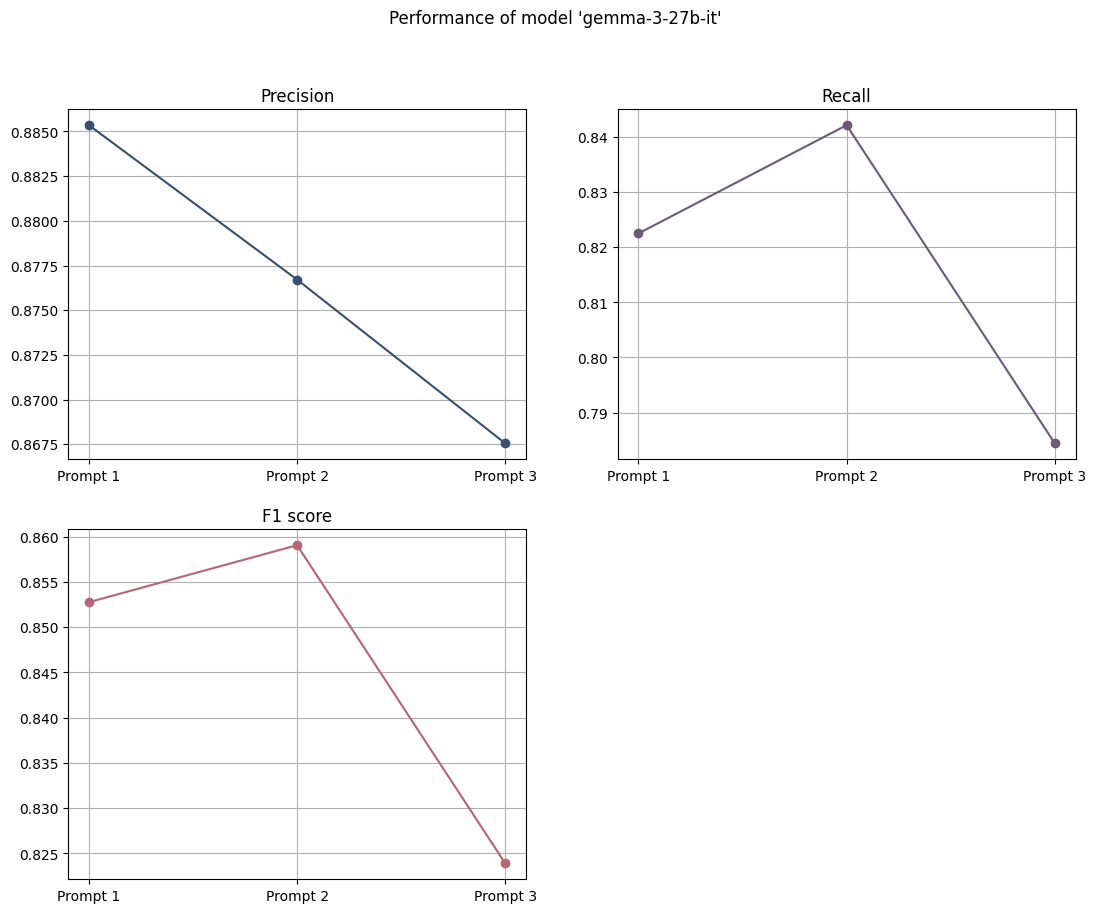

In [ ]:
x = np.array(["Prompt 1","Prompt 2","Prompt 3"])

plt.subplot(2, 2, 1)
y = np.array(y_precision[9:])
plt.title("Precision")
plt.plot(x,y, color='#355070', marker = 'o')
plt.grid()

plt.subplot(2, 2, 2)
y = np.array(y_recall[9:])
plt.title("Recall")
plt.plot(x,y, color='#6d597a', marker = 'o')
plt.grid()

plt.subplot(2, 2, 3)
y = np.array(y_f1_score[9:])
plt.title("F1 score")
plt.plot(x,y, color='#b56576', marker = 'o')
plt.grid()

plt.suptitle("Performance of model 'gemma-3-27b-it'")
plt.show()

### 3.5 - Comparison between models

In [ ]:
y_f1_prompt_1 = np.array([])
y_f1_prompt_2 = np.array([])
y_f1_prompt_3 = np.array([])

for i in range (0, len(y_f1_score), 3):
  y_f1_prompt_1 = np.append(y_f1_prompt_1, y_f1_score[i])
  y_f1_prompt_2 = np.append(y_f1_prompt_2, y_f1_score[i + 1])
  y_f1_prompt_3 = np.append(y_f1_prompt_3, y_f1_score[i + 2])

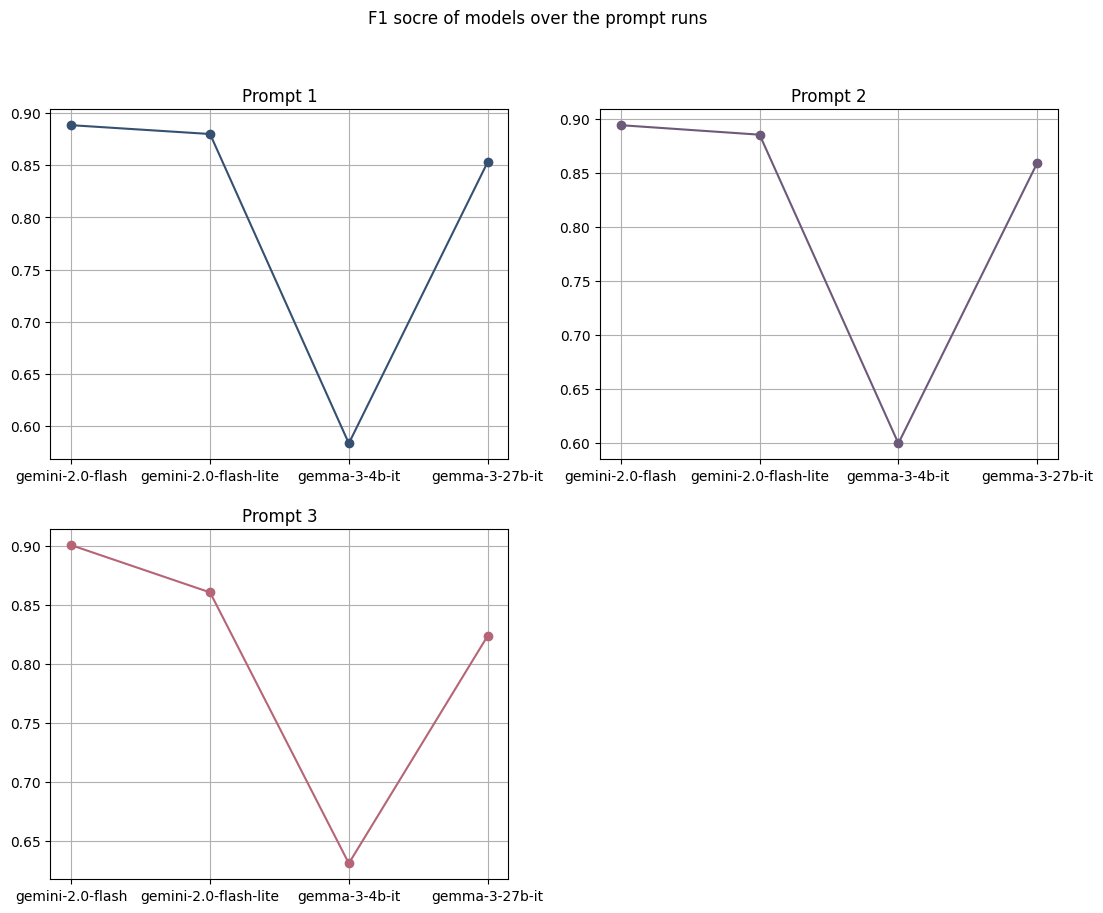

In [ ]:
x = np.array(["gemini-2.0-flash", "gemini-2.0-flash-lite", "gemma-3-4b-it", "gemma-3-27b-it"])

plt.subplot(2, 2, 1)
plt.title("Prompt 1")
plt.plot(x,y_f1_prompt_1, color='#355070', marker = 'o')
plt.grid()

plt.subplot(2, 2, 2)
plt.title("Prompt 2")
plt.plot(x,y_f1_prompt_2, color='#6d597a', marker = 'o')
plt.grid()

plt.subplot(2, 2, 3)
plt.title("Prompt 3")
plt.plot(x,y_f1_prompt_3, color='#b56576', marker = 'o')
plt.grid()

plt.suptitle("F1 socre of models over the prompt runs")
plt.show()